In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from pandas import DataFrame
from numpy import concatenate
from pandas import concat

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import numpy

In [3]:
# Učitavanje skupa podataka, setovanje indexa na kolonu koja sadrži podatke o datumu i vremenu
dataset = pd.read_csv('ukupno.csv').set_index("datumivreme")

In [4]:
dataset.head(5)

,temperatura,vlaznost,pritisak,temperaturaBah,vlaznostBah,pritisakBah,temperaturaBul,vlaznostBul,pritisakBul,temperaturaCro,...,pritisakHun,temperaturaMac,vlaznostMac,pritisakMac,temperaturaMon,vlaznostMon,pritisakMon,temperaturaRom,vlaznostRom,pritisakRom
datumivreme,,,,,,,,,,,,,,,,,,,,,
1/1/18 00:00,2,0.81,1016,1,0.93,1016,-1,1.00,1019,9,...,1014,-2,0.93,1021,1,0.87,1022,1,0.81,1016
1/1/18 01:00,2,0.81,1016,1,0.93,1016,-1,1.00,1019,10,...,1013,-2,0.93,1021,0,0.93,1022,1,0.81,1016
1/1/18 01:30,2,0.81,1016,0,1.00,1016,-2,1.00,1019,10,...,1013,-3,0.93,1021,0,0.87,1022,1,0.87,1016
1/1/18 02:00,1,0.87,1016,1,0.93,1016,-2,1.00,1019,9,...,1013,-3,0.93,1021,1,0.81,1022,2,0.81,1016
1/1/18 02:30,1,0.87,1016,1,0.93,1016,-2,0.93,1019,9,...,1013,-3,0.93,1021,0,0.93,1022,2,0.81,1015


In [5]:
# Prolazimo kroz podatke i pravimo 'parove' odgovrajućih ulaznih podataka sa izlaznim
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
# Uzimamo vrednosti iz skupa podataka, nad kojima prvo radimo normalizaciju kako bi dobili sve vrednosti u intervalu od 0 do 1
# Zatim pozivamo gorespomenutu funkciju koja će podeliti i pripremiti podatke za dalji rad
values = dataset.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)

In [7]:
# Odbacujemo visak kolona
reframed.drop(reframed.columns[25:48], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.346939   0.773810       0.52   0.165138      0.184   0.031884   
2   0.346939   0.773810       0.52   0.165138      0.184   0.031884   
3   0.346939   0.773810       0.52   0.155963      0.198   0.031884   
4   0.326531   0.845238       0.52   0.165138      0.184   0.031884   
5   0.326531   0.845238       0.52   0.165138      0.184   0.031884   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)    ...     var16(t-1)  \
1   0.339623   1.000000   0.644445        0.50    ...       0.235294   
2   0.339623   1.000000   0.644445        0.52    ...       0.235294   
3   0.320755   1.000000   0.644445        0.52    ...       0.215686   
4   0.320755   1.000000   0.644445        0.50    ...       0.215686   
5   0.320755   0.921348   0.644445        0.50    ...       0.215686   

   var17(t-1)  var18(t-1)  var19(t-1)  var20(t-1)  var21(t-1)  var22(t-1)  \
1    0.921348    0.651163    0.166667    0.791667    0.799999  

In [8]:
# Podela podataka na trening i test podatke
values = reframed.values
n_train_hours = 400 * 48
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [9]:
# Podela trening i test skupa podataka na ulazne i izlazne podatke
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1],test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [10]:
# Kreiranje i treniranje LSTM modela upotrebom Keras biblioteke
model = Sequential()
model.add(GRU(units = 50, activation='relu',input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(train_X, train_y, epochs = 25, batch_size = 32)
loss = history.history['loss']
epochs = range(len(loss))

Epoch 1/25
19200/19200 [==============================] - 1s 58us/step - loss: 0.0068
Epoch 2/25
19200/19200 [==============================] - 1s 35us/step - loss: 6.9019e-04
Epoch 3/25
19200/19200 [==============================] - 1s 35us/step - loss: 4.4139e-04
Epoch 4/25
19200/19200 [==============================] - 1s 35us/step - loss: 3.5315e-04
Epoch 5/25
19200/19200 [==============================] - 1s 35us/step - loss: 3.3895e-04
Epoch 6/25
19200/19200 [==============================] - 1s 34us/step - loss: 3.2488e-04
Epoch 7/25
19200/19200 [==============================] - 1s 34us/step - loss: 3.2588e-04
Epoch 8/25
19200/19200 [==============================] - 1s 34us/step - loss: 3.2809e-04
Epoch 9/25
19200/19200 [==============================] - 1s 35us/step - loss: 3.2178e-04
Epoch 10/25
19200/19200 [==============================] - 1s 34us/step - loss: 3.1917e-04
Epoch 11/25
19200/19200 [==============================] - 1s 37us/step - loss: 3.2851e-04
Epoch 12/25


In [12]:
# Predikcija vrednosti na osnovu podataka za testiranje
y_predicted = model.predict(test_X)

In [13]:
# Vracanje vrednosti u originalne vrednosti ('obrnuta normalizacija')
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X=test_X.astype('float32',casting='same_kind')
y_predicted_descaled = concatenate((y_predicted, test_X[:, 1:]), axis=1)
y_predicted_descaled = scaler.inverse_transform(y_predicted_descaled)
y_predicted_descaled = y_predicted_descaled[:,0]

In [14]:
test_y = test_y.reshape((len(test_y), 1))
y_test_descaled = concatenate((test_y, test_X[:, 1:]), axis=1)
y_test_descaled = scaler.inverse_transform(y_test_descaled)
y_test_descaled = y_test_descaled[:,0]

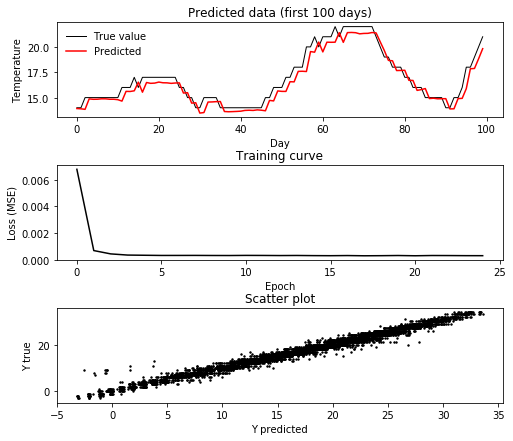

In [15]:
plt.figure(figsize=(8,7))


plt.subplot(3, 1, 1)
plt.plot(y_test_descaled[0:100], color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled[0:100], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Day")
plt.title("Predicted data (first 100 days)")

plt.subplot(3, 1, 2)
plt.plot(epochs, loss, color='black')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 1, 3)
plt.scatter(y_predicted_descaled, y_test_descaled, s=2, color='black')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace =
                    0.5, wspace=0.3)

plt.savefig("SCLSTMAllData.png",  bbox_inches = "tight")


plt.show()

In [16]:
mse = metrics.mean_squared_error(y_test_descaled, y_predicted_descaled)
mae = metrics.mean_absolute_error(y_test_descaled, y_predicted_descaled)
print("mse =" + str(round(mse,2)))
print("mae =" + str(round(mae,2)))

mse =1.26
mae =0.79
